In [2]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser, relativedelta
from IPython.display import display

pd.options.mode.chained_assignment = None  # default='warn'

def x_translation (x_ver, row):
    x_ch = row['x']
    x_n = x_ch - x_ver
    return  x_n

def z_translation (z_ver, row):
    z_ch = row['z']
    z_n = z_ch - z_ver
    return z_n

# calculate arc that the body needs to rotate to get both shoulders on the same z-coordinate
def define_arc(frame):
    x_left = frame.loc[frame['jointName'] == "ShoulderLeft", 'xToOrigin'].values[0]
    z_left = frame.loc[frame['jointName'] == "ShoulderLeft", 'zToOrigin'].values[0]
    arc = math.atan(abs(z_left)/abs(x_left))
    return arc

# rotate a given point and calculate new x and new z
def rotate_body_x(row, arc):
    new_x = (math.cos(arc) * float(row['xToOrigin'])) - (math.sin(arc) * float(row['zToOrigin']))
    return new_x

def rotate_body_z(row, arc):
    new_z = (math.cos(arc) * float(row['zToOrigin'])) + (math.sin(arc) * float(row['xToOrigin'])) 
    return new_z

def rotate_body(df):
    # create empty DataFrame
    index = np.arange(0)
    frames = pd.DataFrame(index=index)
    frames = frames.fillna(0) # with 0s rather than NaNs

    # get frames from one exercise
    frame_max = int(df['frameNum'].max())
    frame_min = int(df['frameNum'].min())

    # go through all frames of an exercise
    for i in range(frame_min, frame_max + 1):   
        frame = df.loc[df['frameNum'] == i]
        
        # define translation to place vectors in origin
        x_ver = frame.x.where(frame.jointName == "ShoulderRight").dropna()
        z_ver = frame.z.where(frame.jointName == "ShoulderRight").dropna()
        x_ver = x_ver.values[0]
        z_ver = z_ver.values[0]

        # translate
        frame['xToOrigin'] = frame.apply(lambda row: x_translation(x_ver, row),axis=1)
        frame['zToOrigin'] = frame.apply(lambda row: z_translation(z_ver, row),axis=1)

        zShoulderRight = frame.loc[frame['jointName'] == "ShoulderRight", 'z']
        zShoulderLeft = frame.loc[frame['jointName'] == "ShoulderLeft", 'z']

        # decide if the body clockwise or counterclockwise rotation needs
        if zShoulderRight.values[0] < zShoulderLeft.values[0]:
            # rotate clockwise
            clock = 1
        else:
            # rotate - clockwise
            clock = -1

        #rotate body
        arc = define_arc(frame)
        frame['xRotated'] = frame.apply (lambda row: rotate_body_x(row, arc * clock),axis=1)
        frame['zRotated'] = frame.apply (lambda row: rotate_body_z(row, arc * clock),axis=1)

        frames = frames.append(frame)    
    return frames


# # Arcs in exercises

# In[114]:

def calculate_arc(frame, eNum, side):  
    een = [1, 4, 5]
    twee = [2, 6, 7]
    drie = [3, 8, 9]
    
    # which exercise is done in the given dataframe
    if (eNum in een) or (eNum in twee):
        # which coördinate is needed for the desired arc
        if eNum in een:
            coordinate_one = 'xRotated'
            coordinate_two = 'y'
        elif eNum in twee:
            coordinate_one = 'y'
            coordinate_two = 'zRotated'
        
        # neemt eerste waarde, hoeft niet de goede waarde te zijn!!
        spineShoulder = np.matrix([[frame.loc[frame['jointName'] == 'SpineShoulder', coordinate_one].values[0]], 
                               [frame.loc[frame['jointName'] == 'SpineShoulder', coordinate_two].values[0]]])
        spineMid = np.matrix([[frame.loc[frame['jointName'] == 'SpineMid', coordinate_one].values[0]], 
                               [frame.loc[frame['jointName'] == 'SpineMid', coordinate_two].values[0]]])
        spineMid_new = spineMid - spineShoulder
        
        if side == 'l':
            # left side
            jointName_shoulder = "ShoulderLeft"
            jointName_elbow = "ElbowLeft"
        elif side == 'r':
            # right side
            jointName_shoulder = "ShoulderRight"
            jointName_elbow = "ElbowRight"
        
        shoulder = np.matrix([[frame.loc[frame['jointName'] == jointName_shoulder, coordinate_one].values[0]], 
                        [frame.loc[frame['jointName'] == jointName_shoulder, coordinate_two].values[0]]])
        elbow = np.matrix([[frame.loc[frame['jointName'] == jointName_elbow, coordinate_one].values[0]], 
                        [frame.loc[frame['jointName'] == jointName_elbow, coordinate_two].values[0]]])
        elbow_new = elbow - shoulder
        
        sum_vectors = np.dot(np.transpose(spineMid_new), elbow_new)
        multiplication_lengths = np.linalg.norm(spineMid_new) * np.linalg.norm(elbow_new)
        
    else:
        if side == 'r':
            # right side
            jointName_elbow = "ShoulderRight"
            jointName_wrist = "WristRight"
        else:
            # left side
            jointName_elbow = "ShoulderLeft"
            jointName_wrist = "WristLeft"
            
        elbow = np.matrix([[frame.loc[frame['jointName'] == jointName_elbow, 'xRotated'].values[0]], 
                            [frame.loc[frame['jointName'] == jointName_elbow, 'zRotated'].values[0]]])
        wrist = np.matrix([[frame.loc[frame['jointName'] == jointName_wrist, 'xRotated'].values[0]], 
                            [frame.loc[frame['jointName'] == jointName_wrist, 'zRotated'].values[0]]])
        
        wrist_new = wrist - elbow
        front_vector = np.matrix([[0],[-1]])

        sum_vectors = np.dot(np.transpose(front_vector), wrist_new)
        multiplication_lengths = np.linalg.norm(front_vector) * np.linalg.norm(wrist_new)
    
    cos_alpha = sum_vectors / multiplication_lengths
    alpha = np.arccos(cos_alpha) * 180 / math.pi
    
    if eNum in een:
        if side == 'r':
            if(elbow_new[0,0] < spineMid_new[0,0] and elbow_new[1,0] > spineMid_new[1,0]):
                alpha = 360 - alpha
        else:
            if(elbow_new[0,0] > spineMid_new[0,0] and elbow_new[1,0] > spineMid_new[1,0]):
                alpha = 360 - alpha
    elif eNum in twee:
        # Waarmee vergelijken?????????????????????
        if (elbow_new[0,0] > 0) and (elbow_new[1,0] > 0):
#             print(frame.frameNum.unique())
#             print('elbow_new: ', elbow_new)
#             print('spineMid_new: ', spineMid_new)
#             print(elbow_new[0,0], spineMid_new[0,0], elbow_new[1,0], spineMid_new[1,0], alpha, 360 - alpha) 
            alpha = 360 - alpha
                
    return alpha     

def calculate_deviation(frame, eNum, side):
    een = [1, 4, 5]
    twee = [2, 6, 7]
    drie = [3, 8, 9]
    
    if(eNum in een):
        if(side == 'r'):
            shoulder_name = 'ShoulderRight'
            elbow_name = 'ElbowRight'
        else:
            shoulder_name = 'ShoulderLeft'
            elbow_name = 'ElbowLeft'
        
        
        shoulder = np.matrix([[frame.loc[frame['jointName'] == shoulder_name, 'xRotated'].values[0]], 
                               [frame.loc[frame['jointName'] == shoulder_name, 'y'].values[0]],
                             [frame.loc[frame['jointName'] == shoulder_name, 'zRotated'].values[0]]])
        elbow = np.matrix([[frame.loc[frame['jointName'] == elbow_name, 'xRotated'].values[0]], 
                               [frame.loc[frame['jointName'] == elbow_name, 'y'].values[0]],
                             [frame.loc[frame['jointName'] == elbow_name, 'zRotated'].values[0]]])
        elbow_transpose = np.matrix([[frame.loc[frame['jointName'] == elbow_name, 'xRotated'].values[0]], 
                               [frame.loc[frame['jointName'] == elbow_name, 'y'].values[0]],
                             [frame.loc[frame['jointName'] == shoulder_name, 'zRotated'].values[0]]])
        
        elbow_vector = shoulder - elbow
        elbowl_transpose_vector = shoulder - elbow_transpose

        sum_vectors = np.dot(np.transpose(elbow_vector), elbowl_transpose_vector)
        multiplication_lengths = np.linalg.norm(elbow_vector) * np.linalg.norm(elbowl_transpose_vector)

        cos_alpha = sum_vectors / multiplication_lengths
        beta = np.arccos(cos_alpha) * 180 / math.pi

        if(elbow[2] < shoulder[2] and elbow[1] > shoulder[1]):
            beta = beta*-1

        return(beta)


def get_arcs(df, pNum, eNum, side):
#     df = df.loc[df['eNum'] == eNum]
    if(pNum == 96):
        print(df)
    frame_max = int(df['frameNum'].max())
    frame_min = int(df['frameNum'].min())
    # arcs = arcs.fillna(0) # with 0s rather than NaNs

    if side == 'lr':
        columns = ['pNum','eNum', 'frameNum', 'arc_right', 'arc_left', 'deviation_right', 'deviation_left']
        arcs = pd.DataFrame(index=np.arange(0), columns=columns).fillna(0)

        for i in range(frame_min, frame_max + 1): 
            frame = df.loc[df['frameNum'] == i]

            right_arc = calculate_arc(frame, eNum, 'r')
            left_arc = calculate_arc(frame, eNum, 'l')
            
            right_deviation = calculate_deviation(frame, eNum, 'r')
            left_deviation = calculate_deviation(frame, eNum, 'r')

            row = {'pNum':pNum, 'eNum':eNum, 'frameNum': i, 'arc_right': right_arc[0,0], 'arc_left': left_arc[0,0], 'deviation_right': right_deviation[0,0], 'deviation_left': left_deviation[0,0]}
            arcs = arcs.append(row, ignore_index=True)  
        

    else:
        columns = ['pNum', 'eNum', 'frameNum', 'arc']
        arcs = pd.DataFrame(index=np.arange(0), columns=columns)

        for i in range(frame_min, frame_max + 1): 
            frame = df.loc[df['frameNum'] == i]

            arc = calculate_arc(frame, eNum, side)
            
            deviation = calculate_deviation(frame, eNum, side)
            
            row = {'pNum':pNum, 'eNum':eNum, 'frameNum': i, 'arc': arc[0,0], 'deviation': deviation[0,0]}
            arcs = arcs.append(row, ignore_index=True)            

    return arcs

def relative_time(df, row, first_frame):
    if row == first_frame:
        return 0
    
    time_row = df.loc[df['frameNum'] == row, 'time']
    time_row = time_row.iloc[0]
    time_first_frame = df.loc[df['frameNum'] == first_frame, 'time']
    time_first_frame = time_first_frame.iloc[0]
    
    dt1 = parser.parse(time_row)
    dt2 = parser.parse(time_first_frame)
    delta = relativedelta.relativedelta(dt1, dt2)
    microseconds = delta.seconds * 1000000 + delta.microseconds
    return microseconds

def normalized_time(row, frame):
    total_time = frame['relativeTime'].max()
    
    relative_time = row['relativeTime']
    normalized = relative_time/total_time
    return normalized

def normalize_time(df, eNum, side):
    columns = ['frameNum', 'relativeTime']
    times = pd.DataFrame(index=np.arange(0), columns=columns).fillna(0)
    
    frame_max = int(df['frameNum'].max())
    frame_min = int(df['frameNum'].min())
#     df = df.loc[df['eNum'] == eNum]
    
    for i in range(frame_min, frame_max + 1):
        time_relative = relative_time(df, i, frame_min)
        row = {'frameNum': int(i), 'relativeTime': time_relative}
        times = times.append(row, ignore_index=True)
    
    times['normalized'] = times.apply (lambda row: normalized_time(row, times), axis=1)
    return times

def create_plot(arcs, times, side):
    if side == 'lr':
        plt.plot(times['normalized'], arcs['arc_left'])
        plt.plot(times['normalized'], arcs['arc_right'])

        plt.xlabel('tijd (relatief)')
        plt.ylabel('graden')
        plt.ylim((0,240))
        plt.legend()
        plt.show()

In [3]:
injured = {1:"n",
            2:"n",
            3:"n",
            4:"n",
            5:"n",
            6:"j",
            7:"n",
            8:"n",
            9:"j",
            10:"n",
            11:"n",
            12:"n",
            13:"n",
            14:"n",
            15:"n",
            16:"n",
            17:"j",
            18:"n",
            19:"n",
            20:"j",
            21:"n",
            22:"j",
            23:"j",
            24:"j",
            25:"n",
            26:"n",
            27:"n",
            28:"n",
            29:"n",
            30:"n",
            31:"n",
            32:"n",
            33:"n",
            34:"j",
            35:"n",
            36:"n",
            37:"j",
            38:"n",
            39:"n",
            40:"n",
            41:"n",
            42:"o",
            43:"n",
            44:"n",
            45:"j",
            46:"j",
            47:"n",
            48:"n",
            49:"n",
            50:"j",
            51:"n",
            52:"n",
            53:"n",
            54:"n",
            55:"n",
            56:"n",
            57:"j",
            58:"n",
            59:"n",
            60:"n",
            61:"n",
            62:"n",
            63:"j",
            64:"j",
            65:"n",
            66:"j",
            67:"j",
            68:"n",
            69:"n",
            70:"n",
            71:"j",
            72:"j",
            73:"j",
            74:"n",
            75:"j",
            76:"n",
            77:"n",
            78:"n",
            79:"n",
            80:"j",
            81:"j",
            82:"j",
            83:"n",
            84:"j",
            85:"j",
            86:"j",
            87:"j",
            88:"j",
            89:"j",
            90:"j",
            91:"j",
            92:"j",
            93:"j",
            94:"j",
            95:"j",
            96:"j",
            97:"j",
            98:"j",
            99:"j",
            100:"j",
            101:"j",
            102:"j",
            103:"o",
            104:"j",
            105:"j",
            106:"j",
            107:"j"}

In [4]:
injured = {1:,"g"
            2:,"g"
            3:,"g"
            4:,"g"
            5:,"g"
            6:,"l"
            7:,"g"
            8:,"g"
            9:,"l"
            10:,"g"
            11:,"g"
            12:,"g"
            13:,"g"
            14:,"g"
            15:,"g"
            16:,"g"
            17:,"r"
            18:,"g"
            19:,"g"
            20:,"r"
            21:,"g"
            22:,"r"
            23:,"b"
            24:,"r"
            25:,"g"
            26:,"g"
            27:,"g"
            28:,"g"
            29:,"g"
            30:,"g"
            31:,"g"
            32:,"g"
            33:,"g"
            34:,"l"
            35:,"g"
            36:,"g"
            37:,"l"
            38:,"g"
            39:,"g"
            40:,"g"
            41:,"g"
            42:,"g"
            43:,"g"
            44:,"g"
            45:,"l"
            46:,"b"
            47:,"g"
            48:,"g"
            49:,"g"
            50:,"b"
            51:,"g"
            52:,"g"
            53:,"g"
            54:,"g"
            55:,"g"
            56:,"g"
            57:,"l"
            58:,"g"
            59:,"g"
            60:,"g"
            61:,"g"
            62:,"g"
            63:,"g"
            64:,"g"
            65:,"g"
            66:,"r"
            67:,"l"
            68:,"g"
            69:,"g"
            70:,"g"
            71:,"b"
            72:,"l"
            73:,"r"
            74:,"g"
            75:,"r"
            76:,"g"
            77:,"g"
            78:,"g"
            79:,"g"
            80:,"l"
            81:,"r"
            82:,"r"
            83:,"g"
            84:,"l"
            85:,"l"
            86:,"l"
            87:,"r"
            88:,"l"
            89:,"l"
            90:,"b"
            91:,""
            92:,""
            93:,""
            94:,""
            95:,""
            96:,""
            97:,""
            98:,""
            99:,""
            100:,""
            101:,""
            102:,""
            103:,""
            104:,""
            105:,""
            106:,""
            107:}

SyntaxError: invalid syntax (<ipython-input-4-fd3b9bed7b4a>, line 1)

In [5]:
age = {1:30,
            2:20,
            3:60,
            4:22,
            5:17,
            6:18,
            7:49,
            8:23,
            9:27,
            10:47,
            11:17,
            12:19,
            13:18,
            14:22,
            15:18,
            16:25,
            17:58,
            18:18,
            19:68,
            20:24,
            21:18,
            22:49,
            23:23,
            24:61,
            25:19,
            26:23,
            27:59,
            28:19,
            29:19,
            30:22,
            31:20,
            32:59,
            33:23,
            34:47,
            35:24,
            36:17,
            37:66,
            38:41,
            39:17,
            40:44,
            41:22,
            42:0,
            43:19,
            44:50,
            45:21,
            46:26,
            47:33,
            48:45,
            49:32,
            50:21,
            51:20,
            52:24,
            53:71,
            54:24,
            55:22,
            56:24,
            57:20,
            58:28,
            59:19,
            60:50,
            61:29,
            62:0,
            63:0,
            64:53,
            65:31,
            66:20,
            67:23,
            68:20,
            69:20,
            70:20,
            71:58,
            72:20,
            73:19,
            74:24,
            75:21,
            76:18,
            77:17,
            78:18,
            79:19,
            80:23,
            81:20,
            82:23,
            83:22,
            84:26,
            85:26,
            86:21,
            87:26,
            88:18,
            89:48,
            90:27,
            91:28,
            92:49,
            93:32,
            94:24,
            95:38,
            96:19,
            97:58,
            98:18,
            99:38,
            100:54,
            101:39,
            102:54,
            103:52,
            104:36,
            105:42,
            106:36,
            107:64}

In [6]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser, relativedelta
from IPython.display import display
from scipy.stats.stats import pearsonr


pd.options.mode.chained_assignment = None  # default='warn'

def getValidPersonData(df, pNum, eNum, startFrame, endFrame):
    return df[(df.pNum == pNum) & (df.eNum == eNum) & (df.frameNum >= startFrame) & (df.frameNum <= endFrame)]

def cleanData(df, exercises):
    filteredDataFrame = pd.DataFrame()
    
    for index, row in exercises.iterrows():
        validData = getValidPersonData(df, row.Person, row.Exercise, row.StartFrame, row.FinalFrame)
        if not np.isnan(row.NewExercise):
            validData.eNum = int(row.NewExercise)
        filteredDataFrame = filteredDataFrame.append(validData)
    return filteredDataFrame    

def cleanFile(dataFilename, excelFilename):
    filteredDataFrame = pd.DataFrame()
    combinedData = pd.read_csv(dataFilename)
    excel = pd.ExcelFile(excelFilename)
    excelSheetList = [1, 2, 3, 1.1, 1.2, 2.1, 2.2, 3.1, 3.2]
    for i in excelSheetList:
        exercise = excel.parse("Sheet"+str(i))
        filteredDataFrame = filteredDataFrame.append(cleanData(combinedData, exercise))
        
    if(combinedData.pNum.max() > filteredDataFrame.pNum.max()):
        validDataSize = filteredDataFrame.pNum.max()
        for person in range(validDataSize, combinedData.pNum.max() + 1):
            filteredDataFrame = filteredDataFrame.append(combinedData[(combinedData.pNum == person)])
    
    return filteredDataFrame

In [7]:
df = pd.read_csv('../final_data/rotated.csv')

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df

,Unnamed: 0,frameNum,jointName,x,y,z,orX,orY,orZ,orW,time,trackingId,trackState,pNum,eNum,Side,xToOrigin,zToOrigin,xRotated,zRotated
0,0,733,SpineBase,0.385703,-0.280894,2.303048,"0,007960417","0,9976766","0,03004772","-0,06062357",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.169976,0.014702,-0.170448,-7.432856e-03
1,1,733,SpineMid,0.391797,0.030569,2.321457,"0,007930886","0,9976165","0,03005553","-0,06160391",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.163882,0.033111,-0.166790,1.161026e-02
2,2,733,Neck,0.395201,0.331969,2.326467,"0,003421624","0,997991","-0,0073698","-0,06283215",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.160477,0.038121,-0.164062,1.701898e-02
3,3,733,Head,0.407601,0.473992,2.323310,0,0,0,0,20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.148078,0.034964,-0.151359,1.549420e-02
4,4,733,ShoulderLeft,0.228997,0.221285,2.331009,"0,7792636","-0,6260335","-0,02735545","-0,009047253",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.326682,0.042663,-0.329456,6.938894e-18
5,5,733,ElbowLeft,0.169492,-0.063021,2.343276,"0,7369","-0,09050103","-0,667786","-0,0533836",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.386187,0.054930,-0.390048,4.458060e-03
6,6,733,WristLeft,0.128614,-0.272049,2.324973,"0,8601683","-0,06156142","-0,4990123","-0,08548366",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.427065,0.036627,-0.428212,-1.898433e-02
7,7,733,HandLeft,0.138438,-0.341842,2.326526,"0,8518918","0,05391425","-0,5189207","0,04576922",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,-0.417240,0.038180,-0.418671,-1.617217e-02
8,8,733,ShoulderRight,0.555678,0.208734,2.288346,"0,79843","0,5911304","-0,07047994","-0,09003863",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,0.000000,0.000000,0.000000,0.000000e+00
9,9,733,ElbowRight,0.618152,-0.067171,2.285103,"0,6763929","0,07139259","0,7280903","-0,08532345",20:53:02.4966953,72057594037935192,Tracked,1,1,NaN,0.062473,-0.003243,0.062367,4.874288e-03


In [9]:
new_df_rotated_bodies = pd.DataFrame(index=np.arange(0)).fillna(0)
new_df_all_arcs = pd.DataFrame(index=np.arange(0)).fillna(0)

e = 1
df_pNums = df['pNum'].unique()
for p in df_pNums[:85]: #  voor eerste 10 personen
    df_one_person = df.loc[df['pNum'] == p]
    df_rotated = df_one_person[df_one_person['eNum'] == e]
    new_df_rotated_bodies = new_df_rotated_bodies.append(df_rotated)
    arcs = get_arcs(df_rotated, p, e, 'r') # beide armen bewegen
    new_df_all_arcs = new_df_all_arcs.append(arcs)
    norm_times = normalize_time(df_rotated, e, 'r')
new_df_rotated_bodies # alle geroteerde lichamen
new_df_all_arcs # alle hoeken per persoon

,pNum,eNum,frameNum,arc,deviation
0,1.0,1.0,733.0,13.278830,0.987213
1,1.0,1.0,734.0,11.728706,0.996377
2,1.0,1.0,735.0,11.275998,1.026902
3,1.0,1.0,736.0,11.210309,1.123173
4,1.0,1.0,737.0,11.084392,1.206667
5,1.0,1.0,738.0,11.246189,1.177769
6,1.0,1.0,739.0,11.637833,1.139245
7,1.0,1.0,740.0,12.126686,1.212326
8,1.0,1.0,741.0,12.856746,1.437159
9,1.0,1.0,742.0,13.454386,1.699504


In [10]:
new_df_all_arcs

,pNum,eNum,frameNum,arc,deviation
0,1.0,1.0,733.0,13.278830,0.987213
1,1.0,1.0,734.0,11.728706,0.996377
2,1.0,1.0,735.0,11.275998,1.026902
3,1.0,1.0,736.0,11.210309,1.123173
4,1.0,1.0,737.0,11.084392,1.206667
5,1.0,1.0,738.0,11.246189,1.177769
6,1.0,1.0,739.0,11.637833,1.139245
7,1.0,1.0,740.0,12.126686,1.212326
8,1.0,1.0,741.0,12.856746,1.437159
9,1.0,1.0,742.0,13.454386,1.699504


[  1.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  39.  41.  42.  43.  44.  45.  46.  47.  48.
  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  64.
  65.  66.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  84.  85.  87.  88.  89.  90.  91.]


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


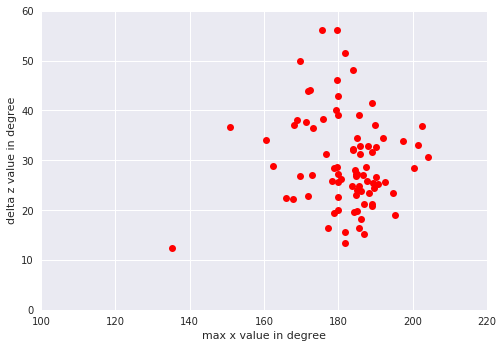

In [11]:
unique_pNums= new_df_all_arcs['pNum'].unique()
print(unique_pNums)
angleindex = np.arange(0)
anglecolumns = ['xmax', 'zdelta']

angle = pd.DataFrame(index = angleindex, columns = anglecolumns)

patientcolumns = ['pnum', 'xmax', 'zdelta', 'marker', 'age']
patients = pd.DataFrame(index = angleindex, columns = patientcolumns)
markers = np.array(unique_pNums)

for p in unique_pNums:
    person = new_df_all_arcs.loc[new_df_all_arcs['pNum'] == p]
    maxx = person['arc'].max()

    maxz = person['deviation'].max()
    minz = person['deviation'].min()
    deltaz = maxz - minz

    row = {'xmax': maxx, 'zdelta': deltaz}
    
    if injured[p]=="j":
        prow = {'pnum': p, 'xmax': maxx, 'zdelta': deltaz, 'marker': 'x', 'age': age[p]}
    else:
        prow = {'pnum': p, 'xmax': maxx, 'zdelta': deltaz, 'marker': 's', 'age': age[p]}

    angle = angle.append(row, ignore_index=True)
    
    patients = patients.append(prow, ignore_index=True)
    
# for p in unique_pNums[60:79]:
#     person = new_df_all_arcs.loc[new_df_all_arcs['pNum'] == p]
#     maxx = person['arc_right'].max()

#     maxz = person['deviation_right'].max()
#     minz = person['deviation_right'].min()
#     deltaz = maxz - minz

#     row = {'xmax': maxx, 'zdelta': deltaz}

#     anglezuid = anglezuid.append(row, ignore_index=True)

plt.plot(angle['xmax'], angle['zdelta'], 'ro')
# plt.plot(anglezuid['xmax'], anglezuid['zdelta'], 'ro', color = 'green')
plt.xlabel('max x value in degree')
plt.ylabel('delta z value in degree')
plt.xlim(100, 220)
plt.ylim(0, 60)
plt.plot()
plt.show()

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


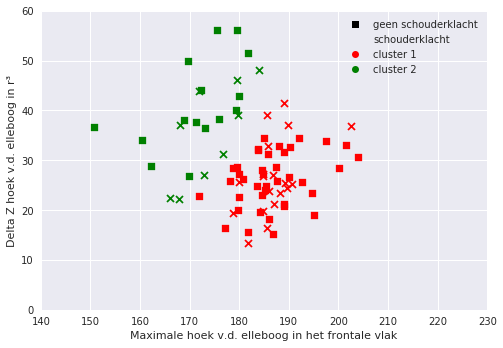

[[ 186.72557126   26.30083216]
 [ 171.21297081   39.77016523]]


In [12]:
from sklearn.cluster import KMeans

plt.clf()

kmeans = KMeans(n_clusters=2, random_state=1).fit(angle)
labels = kmeans.labels_
center = kmeans.cluster_centers_
centerx = center[:,0]
centery = center[:,1]

for index, row in patients.iterrows():
    plt.scatter(row['xmax'], row['zdelta'], c = 'red' if labels[index] == 0 else 'green', marker = row['marker'])

# plt.scatter(angle['xmax'], angle['zdelta'], c = labels)
# plt.scatter(centerx, centery, marker = 'D', color = 'black', label="cluster center")
plt.xlabel('Maximale hoek v.d. elleboog in het frontale vlak')
plt.ylabel('Delta Z hoek v.d. elleboog in r³')
plt.xlim(140, 230)
plt.ylim(0, 60)

not_injured_legend = plt.Line2D((0,1),(0,0), color='k', marker='s', linestyle='')
injured_legend = plt.Line2D((0,1),(0,0), color='k', marker='x', linestyle='')
cluster1_legend = plt.Line2D((0,1),(0,0), color='red', marker='o', linestyle='')
cluster2_legend = plt.Line2D((0,1),(0,0), color='green', marker='o', linestyle='')
# cluster_center_legend = plt.Line2D((0,1),(0,0), color='black', marker='D', linestyle='')

plt.legend([not_injured_legend, injured_legend, cluster1_legend, cluster2_legend],["geen schouderklacht", "schouderklacht", "cluster 1", "cluster 2"],loc="upper right")

plt.plot()
plt.show()

print(center)
# plt.rcParams.update(plt.rcParamsDefault)